In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# device, cuda if available else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **1 - Download Mnist :**
* Transformations defined for loading :
    * Convert the image to a tensor.
    * Normalize : $\mu = 0.5$ and $\sigma = 0.5$.

In [2]:
# list of transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

# download train and test set
train = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# **2 - Define the network's architecture :**
* Generator and discriminator

In [3]:
# dimension of the latent variable z
nz = 100
# dimnesion of the generator's output/discriminator's input (an mnist image)
dim = train.train_data.size(1)*train.train_data.size(2)

In [4]:
class Generator(nn.Module):
    def __init__(self, nz, out_dim):
        """
        Generator's architecture
        Linear layers (increasing dimension nz -> dim mnist)
        Leaky relu activations for intermediary layers + tanh for the last layer
        """
        super(Generator, self).__init__()       
        self.lin1 = nn.Linear(nz, 256)
        self.lin2 = nn.Linear(self.lin1.out_features, self.lin1.out_features*2)
        self.lin3 = nn.Linear(self.lin2.out_features, self.lin2.out_features*2)
        self.lin4 = nn.Linear(self.lin3.out_features, out_dim)
    
    def forward(self, x): 
        x = F.leaky_relu(self.lin1(x), 0.2)
        x = F.leaky_relu(self.lin2(x), 0.2)
        x = F.leaky_relu(self.lin3(x), 0.2)
        return torch.tanh(self.lin4(x))
    
netG = Generator(nz = nz, out_dim = dim).to(device)
print(netG)

Generator(
  (lin1): Linear(in_features=100, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=1024, bias=True)
  (lin4): Linear(in_features=1024, out_features=784, bias=True)
)


In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        """
        Discriminator's architecture
        Linear layers (dim mnist -> nb_classes (=1))
        Leaky relu activations + droupout for intermediary layers + sigmoid for the last layer
        """
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(input_dim, 1024)
        self.lin2 = nn.Linear(self.lin1.out_features, self.lin1.out_features//2)
        self.lin3 = nn.Linear(self.lin2.out_features, self.lin2.out_features//2)
        self.lin4 = nn.Linear(self.lin3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.lin1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.lin2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.lin3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.lin4(x))
    
netD = Discriminator(dim).to(device)
print(netD)

Discriminator(
  (lin1): Linear(in_features=784, out_features=1024, bias=True)
  (lin2): Linear(in_features=1024, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=256, bias=True)
  (lin4): Linear(in_features=256, out_features=1, bias=True)
)


# **3 - Define the Training Procedure for both the Discriminator and the Generator :**

In [6]:
def trainD(data, batch_size, nz):
    """
    One Gradient step for the Discriminator with data being the input of real images
    """
    netD.zero_grad()

    # get batch of real data
    real_images = images.view(-1, dim).to(device) # sample images from dataloader (x follows p_data)
    real_labels = torch.full((real_images.size(0),), 1, device=device) # create labels for fake data (1)

    # get batch of fake data
    fake_images = torch.randn(batch_size, nz, device = device) # sample form Gaussian(0, Id)
    fake_images = netG(fake_images) # run generator (x follows p_G)
    fake_labels = torch.full((batch_size,), 0, device=device) # create labels for fake data (0)

    # Compute D output
    D_output_real = netD(real_images).float()
    D_output_fake = netD(fake_images).float()

    # Update D : loss + gradient step 

    # D error
    err_d = criterion(D_output_real,real_labels) + criterion(D_output_fake, fake_labels)
    # one gradient step
    err_d.backward() 
    optim_d.step()

    # logging
    average_d_on_real = D_output_real.mean().item()
    average_d_on_fake = D_output_fake.mean().item()  

    return D_output_real.mean().item(), D_output_fake.mean().item(), err_d.item()

In [7]:
def trainG(batch_size, nz):
    """
    One Gradient step for the Generator
    """
    netG.zero_grad()

    # get batch of fake data
    fake_images = torch.randn(batch_size, nz, device = device) # sample form Gaussian(0, Id)
    fake_images = netG(fake_images) # run generator (x follows p_G)
    fake_labels = torch.full((batch_size,), 1, device=device) # create labels for fake data (0)

    # D output on fake data
    D_output_fake = netD(fake_images).float()

    # Update G : loss + gradient step 

    # G error
    err_g = criterion(D_output_fake ,fake_labels)
    err_g.backward() 
    optim_g.step()

    return err_g.item()

# **4 - Training Loop :**

In [8]:
# parameters
epochs = 200

# optimisation
lr_g = 0.0002
lr_d = 0.0002
# optimizers
optim_g = optim.Adam(netG.parameters(), lr = lr_d)
optim_d = optim.Adam(netD.parameters(), lr = lr_g)
criterion = nn.BCELoss() 

# data
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# noise to display samples during training
noise = torch.randn(batch_size, nz, device=device)

In [9]:
# per epoch logging containers
loss_d = []
loss_g = []
d_on_fake = []
d_on_real = []
sampled_images = []
for epoch in range(epochs):
    print("EPOCH : ",epoch)
    # per gradient step logging containers
    epoch_loss_d = []
    epoch_loss_g = []
    epoch_d_on_fake = []
    epoch_d_on_real = []
    for i, (images, labels) in enumerate(train_loader):
        ############################ 1 - D network :
        average_d_on_real, average_d_on_fake, err_d = trainD(images, batch_size, nz)
        # Per batch logging : 
        epoch_loss_d.append(err_d)
        epoch_d_on_fake.append(average_d_on_fake)
        epoch_d_on_real.append(average_d_on_real)

        ############################## 2 - G network :
        err_g = trainG(batch_size, nz)
        # per batch logging  
        epoch_loss_g.append(err_g)

        ############################## 3 - Logging :

        # display stats and an image during training
        """if i % 300 == 0 :
            print("BATCH :",i)
            print("\t |errG:",epoch_loss_g[i],"| errD:",epoch_loss_d[i],"| D_on_real: ", epoch_d_on_real[i], "| D_on_fake: ", epoch_d_on_fake[i])"""

    # per epoch logging
    loss_d.append(sum(epoch_loss_d) / len(epoch_loss_d))
    loss_g.append(sum(epoch_loss_g) / len(epoch_loss_g))
    d_on_fake.append(sum(epoch_d_on_fake) / len(epoch_d_on_fake))
    d_on_real.append(sum(epoch_d_on_real) / len(epoch_d_on_real))

    # verbose every epoch
    if epoch % 1 == 0 :
        print("|errG:",loss_g[epoch],"| errD:",loss_d[epoch],"| D_on_real: ", d_on_real[epoch], "| D_on_fake: ", d_on_fake[epoch])
        with torch.no_grad():
            netG.eval()
            fake = netG(noise).detach().cpu()
            fake = fake.view(fake.size(0), 1, 28, 28)
        img=vutils.make_grid(fake, padding=2, normalize=True)
        sampled_images.append(img)

EPOCH :  0
|errG: 2.8730932284519075 | errD: 0.9362153118786712 | D_on_real:  0.7673028553028901 | D_on_fake:  0.33786275994653503
EPOCH :  1
|errG: 2.6224987905969224 | errD: 0.9674729458491007 | D_on_real:  0.7347973843415578 | D_on_fake:  0.36009870711093145
EPOCH :  2
|errG: 1.5832922494411468 | errD: 1.0894373834629854 | D_on_real:  0.6804703248043855 | D_on_fake:  0.3869568979740143
EPOCH :  3
|errG: 2.0483200098077456 | errD: 0.9284610664099455 | D_on_real:  0.7438998914261659 | D_on_fake:  0.31653689423576
EPOCH :  4
|errG: 2.817000439365705 | errD: 0.479319527943929 | D_on_real:  0.8678297031919161 | D_on_fake:  0.15811149342606465
EPOCH :  5
|errG: 2.888742404182752 | errD: 0.4805906192213297 | D_on_real:  0.866923384865125 | D_on_fake:  0.14768131867672007
EPOCH :  6
|errG: 3.0624800831079484 | errD: 0.43476797357201574 | D_on_real:  0.8814401855071385 | D_on_fake:  0.13453463743751248
EPOCH :  7
|errG: 2.815338141322136 | errD: 0.5088678893695275 | D_on_real:  0.85094860315

# **5 - RESULTS :**

## 1 - Training loss of both D and G :

Text(0, 0.5, 'D loss')

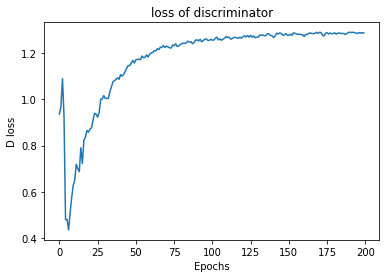

In [10]:
plt.plot(loss_d)
plt.title("loss of discriminator")
plt.xlabel("Epochs")
plt.ylabel("D loss")
#plt.savefig("./losses_mnist/d_loss.png")

Text(0, 0.5, 'G loss')

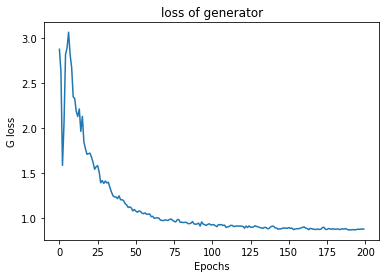

In [11]:
plt.plot(loss_g)
plt.title("loss of generator")
plt.xlabel("Epochs")
plt.ylabel("G loss")
#plt.savefig("./losses_mnist/g_loss.png")

## 2 - D's Mean Prediction on Both Real and Fake Images :

Text(0, 0.5, 'disc prediction')

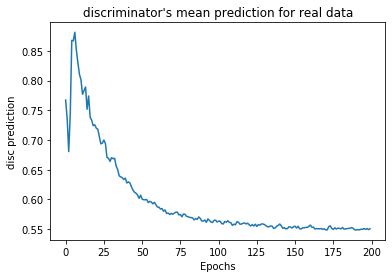

In [12]:
plt.plot(d_on_real)
plt.title("discriminator's mean prediction for real data")
plt.xlabel("Epochs")
plt.ylabel("disc prediction")
#plt.savefig("./losses_mnist/d_on_real.png")

Text(0, 0.5, 'disc prediction')

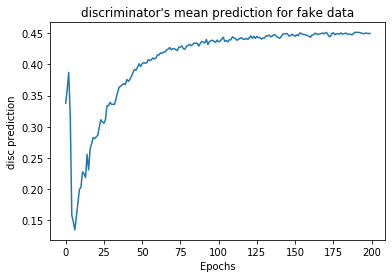

In [13]:
plt.plot(d_on_fake)
plt.title("discriminator's mean prediction for fake data")
plt.xlabel("Epochs")
plt.ylabel("disc prediction")
#plt.savefig("./losses_mnist/d_on_fake.png")

## 3 - Generate an Image :

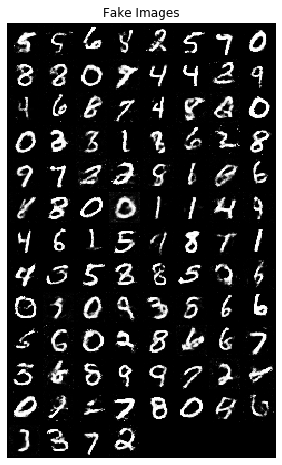

In [14]:
# image of the last epoch
img = sampled_images[-1]
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img.cpu(),(1,2,0)))
plt.show()

In [15]:
"""for i,img in enumerate(sampled_images):
    save_image(img, './fake_mnist/sample_' +str(i)+ '.png')"""

"for i,img in enumerate(sampled_images):\n    save_image(img, './fake_mnist/sample_' +str(i)+ '.png')"